<a href="https://colab.research.google.com/github/fcmf/projeto-aprendizado-descritivo/blob/main/SD_Reincidencia_corrigido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subgroup Discovery com alvo = reincidencia

In [ ]:
!pip install pysubgroup

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 2.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pysubgroup as ps

# Carregar os dados
# Atenção: ajuste o nome do arquivo se diferente
file_path = "violencia_domestica_2023.csv"
df = pd.read_csv(file_path, sep=";")

# Corrigir datas com possíveis valores serializados (Excel)
def corrigir_data(valor):
    try:
        return pd.to_datetime(valor)
    except:
        try:
            num = float(valor)
            return pd.to_datetime("1899-12-30") + pd.to_timedelta(num, unit="D")
        except:
            return pd.NaT

df['data_fato_corrigida'] = df['data_fato'].apply(corrigir_data)
df['dia_da_semana'] = df['data_fato_corrigida'].dt.day_name()
df['fim_de_semana'] = df['dia_da_semana'].isin(['Saturday', 'Sunday']).map({True: 'Sim', False: 'Não'})

# Criar variável de reincidência com base na repetição de local e natureza do delito
df['reincidencia'] = df.duplicated(subset=['municipio_fato', 'natureza_delito'], keep=False).astype(int)

# Selecionar atributos para o SD
atributos = [
    'municipio_fato', 'mes', 'risp', 'rmbh', 'natureza_delito',
    'dia_da_semana', 'fim_de_semana'
]
df_sd = df[atributos + ['reincidencia']].dropna()

# Definir alvo e espaço de busca
target = ps.BinaryTarget('reincidencia', True)
search_space = ps.create_selectors(df_sd, ignore=['reincidencia'])
qf = ps.WRAccQF()

task = ps.SubgroupDiscoveryTask(
    df_sd,
    target,
    search_space,
    qf,
    result_set_size=10,
    depth=3
)

# Executar busca
result = ps.SimpleDFS().execute(task)

# Visualizar os subgrupos encontrados
result_df = result.to_dataframe()
print("\nTop 10 subgrupos com maior reincidência:\n")
print(result_df[['subgroup', 'quality', 'size_sg', 'positives_sg']])



Top 10 subgrupos com maior reincidência:

                                            subgroup   quality  size_sg  \
0                          natureza_delito=='AMEACA'  0.019796    17285   
1  natureza_delito=='AMEACA' AND rmbh=='3) Interi...  0.017034    14963   
2  fim_de_semana=='Não' AND natureza_delito=='AME...  0.013460    11726   
3         natureza_delito=='VIAS DE FATO / AGRESSAO'  0.011885    11495   
4  fim_de_semana=='Não' AND natureza_delito=='AME...  0.011575    10141   
5                  natureza_delito=='LESAO CORPORAL'  0.009991     9780   
6  natureza_delito=='VIAS DE FATO / AGRESSAO' AND...  0.009362     9374   
7  natureza_delito=='LESAO CORPORAL' AND rmbh=='3...  0.008632     8596   
8  fim_de_semana=='Não' AND natureza_delito=='VIA...  0.007276     6910   
9  fim_de_semana=='Sim' AND natureza_delito=='AME...  0.006336     5559   

   positives_sg  
0         17238  
1         14916  
2         11696  
3         11385  
4         10111  
5          9679  
6    

/tmp/ipython-input-7-1273991658.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='quality', y='descrição', data=result_df, palette='viridis')


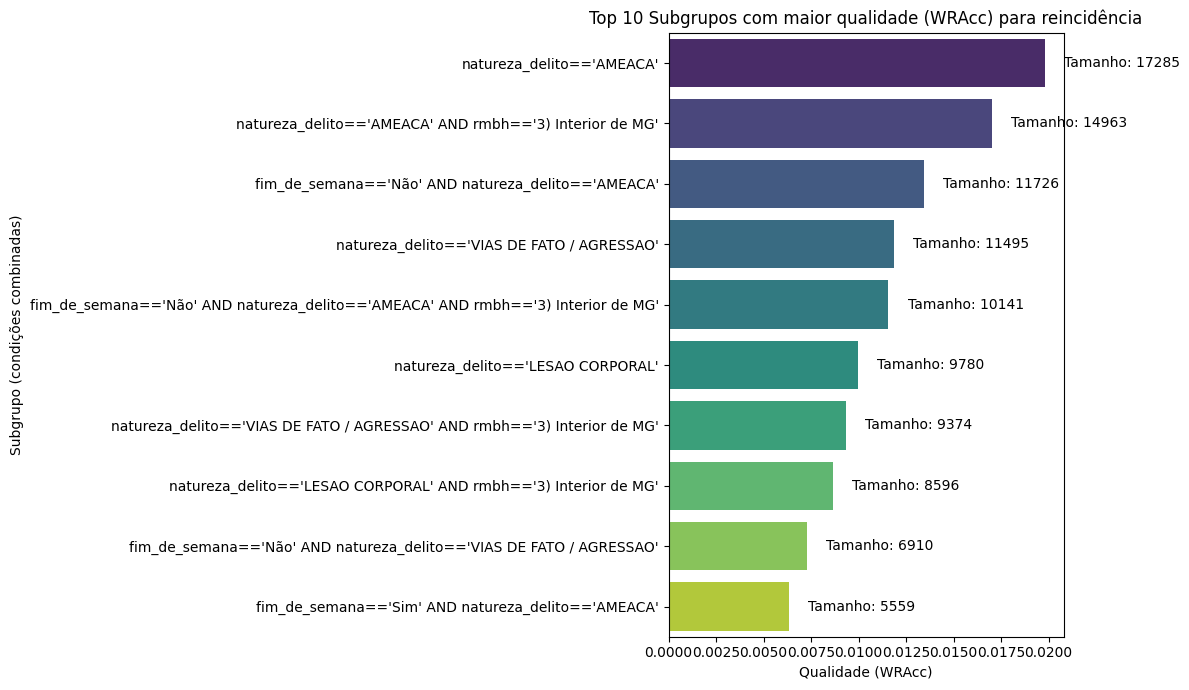

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertendo subgrupo para string legível
result_df['descrição'] = result_df['subgroup'].apply(lambda sg: str(sg))

plt.figure(figsize=(12, 7))

# Gráfico de barras horizontal da qualidade WRAcc
sns.barplot(x='quality', y='descrição', data=result_df, palette='viridis')

plt.title('Top 10 Subgrupos com maior qualidade (WRAcc) para reincidência')
plt.xlabel('Qualidade (WRAcc)')
plt.ylabel('Subgrupo (condições combinadas)')

# Adiciona anotação com tamanho do subgrupo ao lado da barra
for index, row in result_df.iterrows():
    plt.text(row['quality'] + 0.001, index, f"Tamanho: {row['size_sg']}", color='black', va="center")

plt.tight_layout()
plt.show()